In [62]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec
import itertools
import pandas as pd
import numpy as np
import re

In [54]:
#WILL BE TRAINING MY OWN MODEL

#loading pretrained model
# filename = 'GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin'
# model = KeyedVectors.load_word2vec_format(filename, binary=True)

# glove_input_file = 'glove.6B/glove.6B.50d.txt'
# word2vec_output_file = 'glove.6B.50d.txt.word2vec'
# glove2word2vec(glove_input_file, word2vec_output_file)
# filename = 'glove.6B.50d.txt.word2vec'
# model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [136]:
# model['%']

array([-0.9208  ,  0.60392 ,  1.1053  , -0.39188 ,  1.0204  ,  2.1945  ,
       -0.49508 , -1.9547  , -1.0751  ,  0.1454  ,  1.2495  , -1.4208  ,
        1.894   , -1.3024  , -0.1751  ,  0.33084 , -0.17029 ,  0.169   ,
       -0.87306 ,  0.22944 ,  0.027846,  0.33347 ,  1.2866  ,  0.23098 ,
       -0.12257 ,  0.38349 ,  0.24163 , -0.67453 ,  0.08332 ,  0.76547 ,
        3.2612  ,  0.62834 , -0.016612, -0.12178 ,  0.85848 , -1.1687  ,
       -0.10173 ,  0.070155,  0.99368 ,  0.029438, -0.065403, -0.50471 ,
        1.1739  , -0.28263 , -1.381   , -0.43341 , -0.58927 , -0.19344 ,
        1.6497  , -0.10516 ], dtype=float32)

In [8]:
#loading data
headlines = pd.read_csv('FiQA_train_ABSA_financial_headlines.tsv',delimiter='\t',header=0)
posts = pd.read_csv('FiQA_train_ABSA_financial_posts.tsv',delimiter='\t',header=0)
posts = posts.drop(['Unnamed: 0', 'id'],axis=1)
headlines = headlines.drop(['Unnamed: 0', 'id'],axis=1)
posts_text = posts.iloc[:,:1]
posts_score = posts.iloc[:,1:]
headlines_text = headlines.iloc[:,:1]
headlines_score = headlines.iloc[:,1:]
text_frames = [posts_text,headlines_text]
score_frames = [posts_score,headlines_score]
text = pd.concat(text_frames)
score = pd.concat(score_frames)

In [3]:
#finding sentence with max len
max_ = [len(x.split()) for x in text['text']]

Populating the interactive namespace from numpy and matplotlib


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([0.00828169, 0.03603899, 0.10274752, 0.06006498, 0.0385872 ,
        0.03440085, 0.03085156, 0.0253001 , 0.0071896 , 0.00136511]),
 array([ 2. ,  4.9,  7.8, 10.7, 13.6, 16.5, 19.4, 22.3, 25.2, 28.1, 31. ]),
 <a list of 10 Patch objects>)

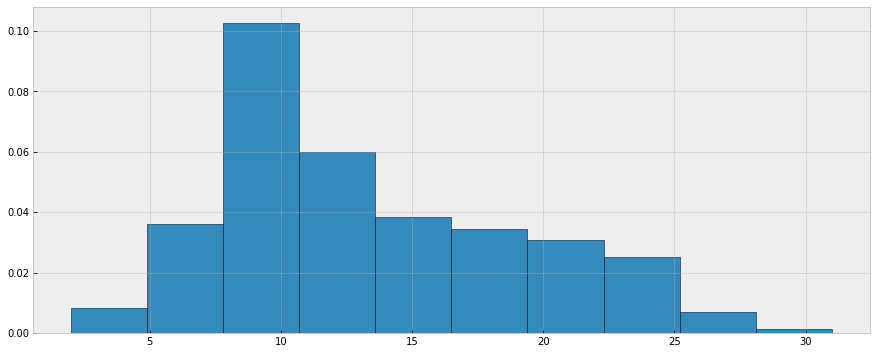

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%pylab inline
plt.style.use('bmh')
pylab.rcParams['figure.figsize'] = (15, 6)
plt.hist(max_, normed=True,edgecolor='black')

In [5]:
max(max_)

31

In [6]:
#max len is 31, not a lot of sentence with len more than 25 so max len be 25
max_len = 25

In [143]:
# get_word_vector('test hitkul function')

In [9]:
sentences = [x for x in text['text']]
# sentences

In [10]:
def clean_sentences(sentence):
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)#removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)#removes links
    sentence = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",sentence).split()) # remove @usernames
    return sentence

In [13]:
for i in range(len(sentences)):
    sentences[i] = clean_sentences(sentences[i])
# sentences

In [81]:
#loading trained model, if not present than train you own vocab
try: 
    model = Word2Vec.load('vocab_model.bin')
except FileNotFoundError:
    train_data_vocab = [x.split() for x in sentences]    
    model = Word2Vec(train_data_vocab,size=10, min_count=5,workers=4) #trying a 10 dimensional vector first
    model.save('vocab_model.bin')

In [82]:
# 

In [83]:
def get_word_vector(sentence):
    vector = []
    for word in sentence.split():
        try:
            vector.append(model[word])
        except KeyError:
            vector.append(np.zeros(10,dtype=float32))
    return np.array(vector).flatten()

In [85]:
# get_word_vector(sentences[0])
text_vectors = [get_word_vector(sentence) for sentence in sentences]

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [97]:
# text_vectors = np.array(text_vectors)
# type(text_vectors)

numpy.ndarray

In [98]:
#converting scores into positive and negative classes
Y = (score>=0).astype(np.int_)
Y['sentiment score'].value_counts()

1    2407
0    1382
Name: sentiment score, dtype: int64

In [100]:
shuffle = np.arange(len(score))
np.random.shuffle(shuffle)
test_train_split = 0.9
train_split, test_split = shuffle[:int(len(score)*test_train_split)], shuffle[int(len(score)*test_train_split):]

In [105]:
# trainX, trainY = text_vectors[train_split,:], to_categorical(Y.values[train_split].ravel(), 2)
# testX, testY = text_vectors[test_split,:], to_categorical(Y.values[test_split].ravel(), 2)
text_vectors.shape

(3789,)